# NTDS 2019 : Assignment 1


[Eda Bayram,](https://lts4.epfl.ch/bayram) [EPFL](http://epfl.ch) [LTS4,](http://lts4.epfl.ch)
Nikolaos Karalias, [EPFL](http://epfl.ch) [LTS2](http://lts2.epfl.ch)

## Students
Team: `<your team number>`

## Rules

* The first deadline is for individual submission, the second one is for the team submission. No collaboration between teams is allowed.
* All team members will receive the same grade for the assignment regarding the solution they submit on the latter deadline.
* However, a team is allowed to ask for individual grading, which will regard the solution submitted on the former deadline.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first and second section, the libraries to be used are given and you cannot import any other library than those. You cannot use Networkx in the first section.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

# Objective 

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

# Dataset : Cora Dataset

The [Cora dataset](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz) consists of scientific publications classified into one of seven research fields. 

* **Citation graph** The citation network can be constructed from the connections given in `cora.cites` file. 
* **Feature graph** Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed regarding the Euclidean distance between the feature vector of the publications.

The `README` file in the dataset provides the details about the content of the files. 

# Section 1 : Network Properties

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Question  1: Construct a Citation Graph and a Feature Graph

Read the cora.content file into a `Pandas` data frame by setting a header for the column names. Check `README` file.

In [2]:
feature_list = list(range(1,1434))
column_list = ['paper_id'] + feature_list + ['class_label'] # Your code here.
pd_content = pd.read_csv('cora/cora.content',delimiter='\t', names=column_list) 
pd_content.head()

,paper_id,1,2,3,4,5,6,7,8,9,...,1425,1426,1427,1428,1429,1430,1431,1432,1433,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use `value_counts()` function from `Pandas`.

In [3]:
pd_content['class_label'].value_counts() # Your code here.

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a `Numpy` array. 

Select all papers from a field of your choice and store their IDsextract their feature vectors into a `numpy` array and check its shape.

In [4]:
my_field = "Neural_Networks" # Your code here.
pd_field = pd_content[pd_content['class_label'] == my_field]
features = pd_field.as_matrix(feature_list) # Your code here.
features.shape

/Users/edabayram/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(818, 1433)

In [5]:
one = np.ones(features.shape[0])
ker = np.matmul(features, features.T)
diagonal = np.diag(ker)
distance = np.sqrt(np.outer(diagonal, one) - 2*ker + np.outer(one,diagonal)) # Your code here.
distance.shape

(818, 818)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [6]:
mean_distance = distance.mean()
mean_distance

5.689638434824233

Plot the histogram of the euclidean distances.

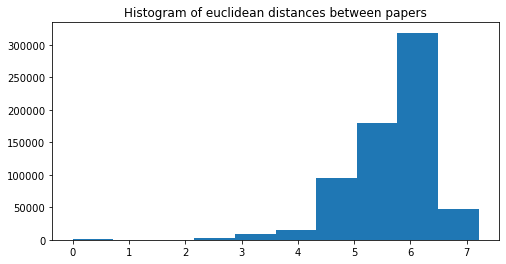

In [7]:
plt.figure(1, figsize=(8,4))
plt.title("Histogram of euclidean distances between papers")
plt.hist(distance.reshape(-1));

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries: $ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j \\ 0, \; \text{otherwise.} \end{cases}$

First, let us choose the mean distance as the threshold.

In [8]:
threshold = mean_distance
A_feature = (distance < threshold).astype(float) - np.eye(distance.shape[0]) # Your code here.

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix. 

In [9]:
cora_cites = np.genfromtxt('cora/cora.cites', delimiter='\t')
#get graph edges and flatten them for processing
edges = cora_cites.astype(int)
edges = edges.flatten()


#get adjacency matrix from edge_list
newedge = pd.factorize(edges)[0]
new_edge_list = newedge.reshape(-1,2)
dim = max(newedge) + 1
adjmat = np.zeros((dim,dim))
adjmat[new_edge_list[:,0],new_edge_list[:,1]] = 1

#caution, matrix is not symmetric at this point 
A_citation = adjmat # Your code here
A_citation.shape

(2708, 2708)

In [10]:
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you choose. You have to appropriately reduce the adjacency matrix of the citation graph.

In [11]:
#map the paper ids from the selected community to the relabeled ones
nodemap = dict(zip(edges, newedge))

community_nodes = [nodemap[i] for i in pd_field.paper_id]

community_adj = A_citation[community_nodes,:]
community_adj = community_adj[:,community_nodes] # Your code here.

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [12]:
A_citation = community_adj + community_adj.T
np.nonzero(A_citation-A_citation.transpose())

(array([], dtype=int64), array([], dtype=int64))

Check the shape of your adjacency matrix again.

In [13]:
A_citation.shape

(818, 818)

### Question 2: Degree Distribution and Moments


What is the total number of edges in each graph?

In [14]:
num_edges_feature = A_feature.sum()/2 # Your code here.
num_edges_citation = A_citation.sum()/2 # Your code here.
print("Number of edges in the feature graph: ", num_edges_feature)
print("Number of edges in the citation graph: ", num_edges_citation)

Number of edges in the feature graph:  136771.0
Number of edges in the citation graph:  1220.0


Plot the degree distribution histogram for each of the graphs.

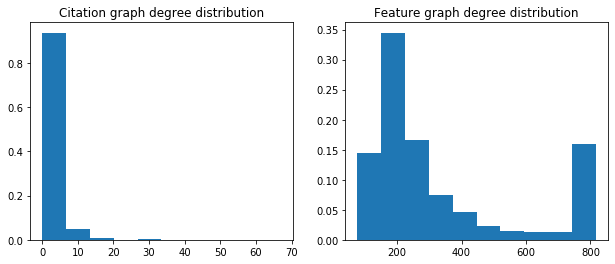

In [15]:
degrees_citation = A_citation.sum(1) # Your code here.
degrees_feature = A_feature.sum(1) # Your code here.

deg_hist_normalization = np.ones(degrees_citation.shape[0])/degrees_citation.shape[0]

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.title('Citation graph degree distribution')
plt.hist(degrees_citation, weights = deg_hist_normalization);
plt.subplot(132)
plt.title('Feature graph degree distribution')
plt.hist(degrees_feature, weights = deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [16]:
degfs, counts_feat = np.unique(degrees_feature,return_counts=True)
degcs, counts_cit = np.unique(degrees_citation,return_counts=True)


degfeatprobs = counts_feat/counts_feat.sum()
degcitprobs = counts_cit/counts_cit.sum()

cit_moment_1 = (degcs*degcitprobs).sum() # Your code here.
cit_moment_2 = (degcs*degcs*degcitprobs).sum() # Your code here.

feat_moment_1 = (degfs*degfeatprobs).sum() # Your code here.
feat_moment_2 = (degfs*degfs*degfeatprobs).sum() # Your code here.

print("1st moment of citation graph: ", (cit_moment_1))
print("2nd moment of citation graph: ", (cit_moment_2))
print("1st moment of feature graph: ", (feat_moment_1))
print("2nd moment of feature graph: ", (feat_moment_2))

1st moment of citation graph:  2.98288508557
2nd moment of citation graph:  25.2004889976
1st moment of feature graph:  334.403422983
2nd moment of feature graph:  167201.198044


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:** 
The first moment of the graph gives us the average degree.
The second moment gives us the variance of the degree distribution.

The citation graph is significantly sparser (recall the number of edges from the previous step). This leads to a sharp spike at low/zero degree nodes and therefore explains the value of the first moment for that graph compared to the second.

For the feature graph we observe from the degree histogram that the tails of the distribution carry a considerable amount of probability density. Notice for example how degree 175 appears more likely than degree 100 even though it's much further from the mean.
This explains the large variance of the second moment and why it is so much larger than the variance of the citation graph which has a much thinner tail.

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

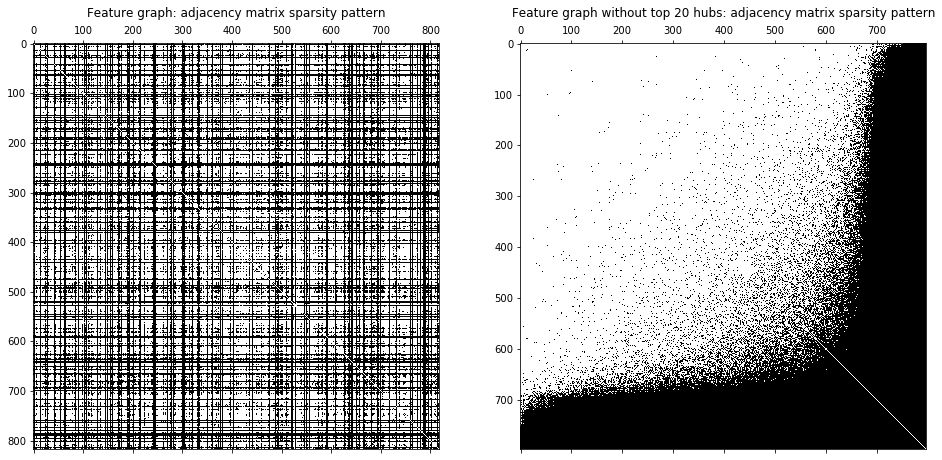

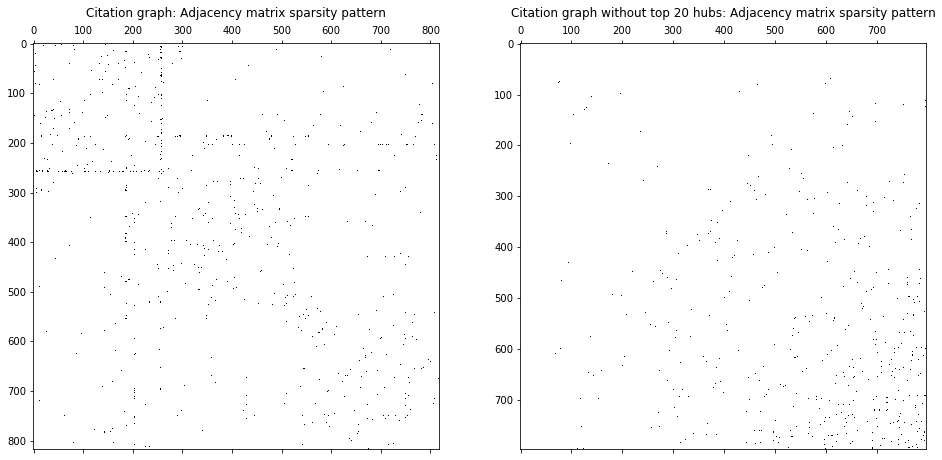

In [17]:
#get degrees of the new unordered one
removed_feat = np.argsort(degrees_feature)[:-20]
removed_cite = np.argsort(degrees_citation)[:-20]

reduced_A_feature = A_feature[removed_feat,:]
reduced_A_feature = reduced_A_feature[:,removed_feat] # Your code here

reduced_A_citation = A_citation[removed_cite,:]
reduced_A_citation = reduced_A_citation[:, removed_cite] # Your code here


plt.figure(1, figsize=(16,8))
plt.subplot(121)
plt.title('Feature graph: adjacency matrix sparsity pattern')
plt.spy(A_feature);
plt.subplot(122)
plt.title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
plt.spy(reduced_A_feature);


plt.figure(2, figsize=(16,8))
plt.subplot(121)
plt.title('Citation graph: Adjacency matrix sparsity pattern')
plt.spy(A_citation);
plt.subplot(122)
plt.title('Citation graph without top 20 hubs: Adjacency matrix sparsity pattern')
plt.spy(reduced_A_citation);

Plot the new degree distribution histograms.

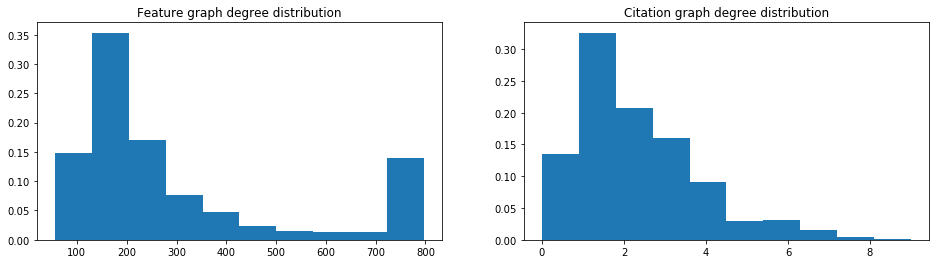

In [18]:
reduced_degrees_feat = reduced_A_feature.sum(1) # Your code here.
reduced_degrees_cit = reduced_A_citation.sum(1) # Your code here.

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

plt.figure(3,figsize=(16,4))
plt.subplot(121)
plt.title('Feature graph degree distribution')
plt.hist(reduced_degrees_feat, weights = deg_hist_normalization);
plt.subplot(122)
plt.title('Citation graph degree distribution')
plt.hist(reduced_degrees_cit, weights = deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [19]:
reduced_degfs, reduced_counts_feat = np.unique(reduced_degrees_feat,return_counts=True)
reduced_degns, reduced_counts_net = np.unique(reduced_degrees_cit,return_counts=True)


reduced_degfeatprobs = reduced_counts_feat/reduced_counts_feat.sum()
reduced_degnetprobs = reduced_counts_net/reduced_counts_net.sum()


#Calculate the 1st and 2nd moments of each graph. Explain the differences.


reduced_cit_moment_1 = (reduced_degns*reduced_degnetprobs).sum() # Your code here.
reduced_cit_moment_2 = (reduced_degns*reduced_degns*reduced_degnetprobs).sum() # Your code here.

reduced_feat_moment_1 = (reduced_degfs*reduced_degfeatprobs).sum() # Your code here.
reduced_feat_moment_2 = (reduced_degfs*reduced_degfs*reduced_degfeatprobs).sum() # Your code here.


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 2.0626566416
Citation graph second moment: 6.97243107769
Feature graph first moment:  302.308270677
Feature graph second moment:  142170.325815


Print the number of edges in the reduced graphs.

In [20]:
print("Feat graph edges", reduced_A_feature.sum()/2) # Your code here
print("Citation graph edges", reduced_A_citation.sum()/2)

Feat graph edges 120621.0
Citation graph edges 823.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:** While the 1st moment is shifted to roughly half of its original value in both cases, the variance of the citation graph seems to be the one most significantly affected. 

Before removing the hubs the highest degree was around 25, with an average degree of 2.833. After removing the hubs the highest degree is around 4 with an average degree 1.412. For the feature graph, the highest degree was around 175 with an average of 64.766. Now the average degree is 34.1875 and the highest degree around 100 with a quite high probability as well. 

The shrinking of the citation graph 2nd moment can be attributed to the fact that its degree distribution is thin-tailed. Thus, the effect of removing hubs becomes more pronounced there. 

### Question 3: Pruning, sparsity,  paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [21]:
threshold = 2.83 # Your code here.

A_feature_pruned = (distance < threshold).astype(float) -np.eye(distance.shape[0]) # Your code here
num_edges_feature_pruned = A_feature_pruned .sum()/2  # Your code here.

print("Number of edges in the feature graph: ", (num_edges_feature))
print("Number of edges in the feature graph after pruning: ", (num_edges_feature_pruned))
print("Number of edges in the citation graph: ", num_edges_citation)

Number of edges in the feature graph:  136771.0
Number of edges in the feature graph after pruning:  1386.0
Number of edges in the citation graph:  1220.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

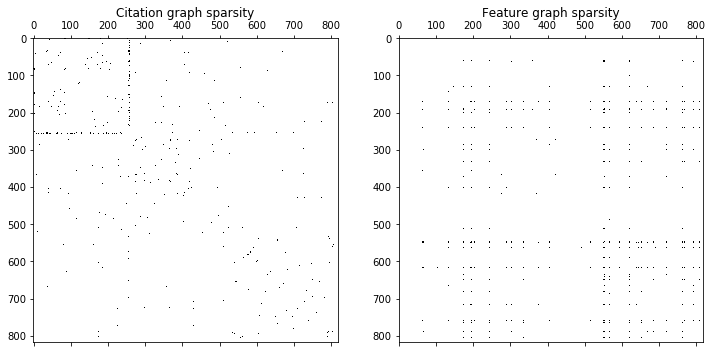

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Citation graph sparsity')
plt.spy(A_citation);
plt.subplot(122)
plt.title('Feature graph sparsity')
plt.spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries:
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j) $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  
**Hint:** Use [the powers of adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [23]:
path_lengths = range(11)


path_matrix_citation = sum([np.linalg.matrix_power(A_citation, k) for k in path_lengths]) # Your code here.
path_matrix_feature = sum([np.linalg.matrix_power(A_feature, k) for k in path_lengths]) # Your code here.

Check the sparsity pattern for both of path matrices.

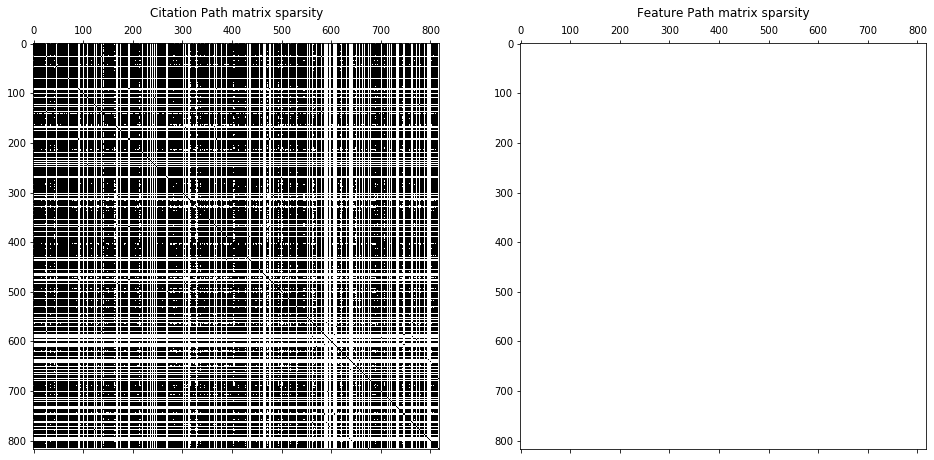

In [24]:
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.title('Citation Path matrix sparsity')
plt.spy(path_matrix_citation);
plt.subplot(122)
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

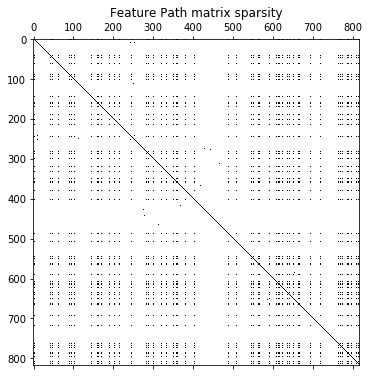

In [25]:
path_matrix_pruned = sum([np.linalg.matrix_power(A_feature_pruned, k) for k in path_lengths]) # Your code here.

plt.figure(figsize=(12,6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:** Yes, the path matrix for the unpruned graph doesn't have zero entries while the one for the pruned graph does.

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** The maximum hop distance between any two nodes in a graph can be on the order of the number of nodes. The [path graph](https://en.wikipedia.org/wiki/Path_graph) is the worst case where one has to traverse all the nodes to get from one endpoint node to the other. By calculating the path matrix for all lengths up to N, where N is the total number of nodes, one expects all the matrix entries to be nonzero, since there will be at least 1 path from all nodes to all other nodes. However, if the graph is not connected, then the path matrix will have zero entries since a subset of nodes will be unreachable by other nodes regardless of the path lengths we consider.
Since the path matrix for the unpruned graph has no zero entries it means that the graph is connected.

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:** You can guess the diameter by finding the path length k at which the path matrix has no zero entries for the first time. Up until that point there will be an entry (i,j) where no paths from i to j exist because the length of paths considered hasn't reached the diameter.

If any of your graphs is connected, calculate the diameter using that process.

In [26]:
path_matrix = np.zeros((A_feature.shape[0],A_feature.shape[0]))
for k in range(11):
    path_matrix += np.linalg.matrix_power(A_feature, k)
    if (path_matrix==0).sum()==0:
        break    

diameter = k# Your code here.
print("The diameter is: ", diameter)

The diameter is:  2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.distance_measures.diameter.html).

Note: Usage of NetworkX is allowed only in this part of Section 1.

In [27]:
from networkx import nx
feature_graph = nx.from_numpy_matrix(A_feature)
print("Diameter according to networkx: ", nx.diameter(feature_graph))

Diameter according to networkx:  2


# Section 2 : Network Models

In this section, you will analyze the feature graph and citation graph you constructed in the previous section in terms of the network model types. For this purpose, you can use NetworkX libary imported below.

In [28]:
import networkx as nx
import warnings
warnings.simplefilter("ignore")

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [29]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 818, Number of edges: 1175
Number of self-loops: 0, Number of connected components: 104


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [30]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 818, Number of edges: 1386
Number of self-loops: 0, Number of connected components: 684


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert model

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation/feature graph.

In [31]:
n = len(G_citation.nodes())
n

818

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [32]:
m = np.round((G_citation.size() + G_feature.size())/2)
m

1280.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:** For the ER network, the expected number of edges is $$E[m] = pn(n-1)/2.$$

In [33]:
p = m*2/(n*(n-1)) # Your code here.
G_er = nx.erdos_renyi_graph(n,p)

Check the number of edges in the Erdős–Rényi graph.

In [34]:
print('My Erdos-Rényi network to simulate citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network to simulate citation graph has 1233 edges.


How do you determine the preferential attachement parameter for Barabási–Albert graphs?

**Your answer here:** For the BA network, m is fixed to $$m = q*(n-q),$$ where $q$ is the model parameter.

In [35]:
q = 2# Your code here.
G_ba = nx.barabasi_albert_graph(n,q)

Check the number of edges in the Barabási–Albert graph.

In [36]:
print('My Barabási-Albert network to simulate citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network to simulate citation graph has 1632 edges.


### Question 5:  Giant component

Check the size of the largest connected component in the citation and feature graph.

In [37]:
giant_citation = max(nx.connected_component_subgraphs(G_citation), key=len) # Your code here.
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 636 nodes and 1079 edges.


In [38]:
giant_feature = max(nx.connected_component_subgraphs(G_feature), key=len) # Your code here.
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 117 nodes and 1364 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [39]:
giant_er = max(nx.connected_component_subgraphs(G_er), key=len) # Your code here.
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 771 nodes and 1226 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

Hint: Recall the expected giant component size from the lectures.

**Your answer here:**  We know from the lectures that in Erdős–Rényi networks, the fraction of nodes in the giant component $$S = \frac{N_G}{N}$$ grows with the average degree by $$S = 1 - e^{-\langle k \rangle S}.$$ Therefore, as $\langle k \rangle = (N-1)p$:

In [40]:
S = giant_feature.number_of_nodes()/ n
p_new = - np.log(1-S)/ (S*(n-1)) # Your code here.
G_er_new = nx.erdos_renyi_graph(n,p_new)

Check the size of the new Erdős–Rényi network and its giant component.

In [41]:
print('My new Erdos Renyi network to simulate citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(nx.connected_component_subgraphs(G_er_new), key=len) # Your code here.
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network to simulate citation graph has 445 edges.
The giant component of the new Erdos-Rényi network has 209 nodes and 208 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

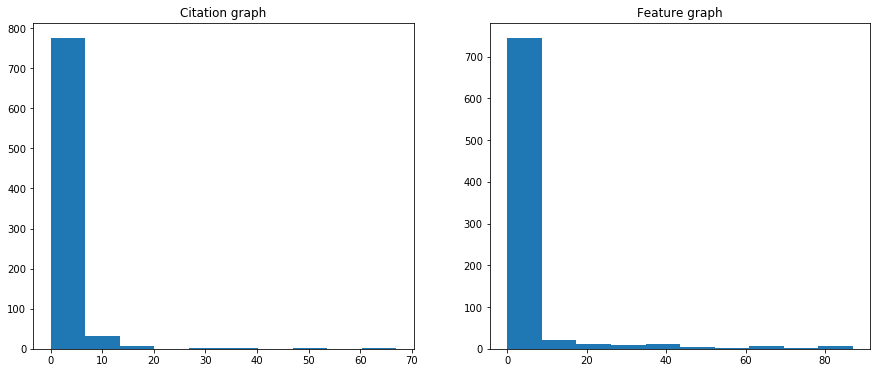

In [42]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Citation graph')
citation_degrees = list(G_citation.degree().values())# Your code here.
plt.hist(citation_degrees);
plt.subplot(122)
plt.title('Feature graph')
feature_degrees = list(G_feature.degree().values())# Your code here.
plt.hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answe here:** The degree distribution may give us a hint about the formation pattern of a network, for example, a power-law degree distribution signifies a scale free network and a binomial distribution is outcome of a random network formation. For the feature and the citation graph, we observe a degree distribution close to a power-law distribution. Hence, we can predict that they might have a scale-free growth.

Now, plot the degree distribution historgrams for the simulated networks.

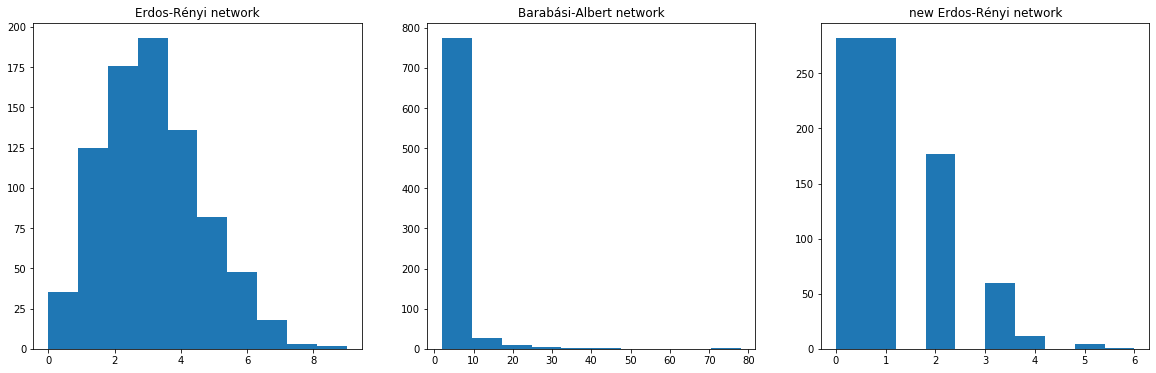

In [43]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title('Erdos-Rényi network')
er_degrees = G_er.degree().values()# Your code here.
plt.hist(er_degrees);
plt.subplot(132)
plt.title('Barabási-Albert network')
ba_degrees = G_ba.degree().values()# Your code here.
plt.hist(ba_degrees);
plt.subplot(133)
plt.title('new Erdos-Rényi network')
er_new_degrees = G_er_new.degree().values()# Your code here.
plt.hist(er_new_degrees);

In terms of the degree distribution, is there a good match between citation and feature graph and the simulated networks? For the citation graph, choose one of the simulated networks above that matches its degree distribution at best. Indicate your preference below:

**Your answer here:** Degree distribution of the citation graph matches that of the Barabási-Albert network at best.

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [44]:
G_config = nx.configuration_model(feature_degrees) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 818 nodes and 1386 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** It does not mean considering the topology. We can prove that they are not the same graph simply by checking the number of connected components for example.

In [45]:
nx.number_connected_components(G_config)

670

### Question 7:  Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [46]:
nx.average_clustering(G_citation)

0.21693567980632222

In [47]:
nx.average_clustering(G_feature)

0.1220744470334593

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:** Clustering coefficient give us a measure about the connectivity pattern of a node to its neighbors and give us a hint about the network model. We obtain small values for a "small-world" network models since they are subject to unexpected wirings to some degree. Relatively large values are observed for the networks having more regular connectivity patterns. By looking at the the values obtained here, we can say that the clustering coeficients of the citation and feature graphs are as large as to show that they are not random.

Now, let us check the average clustering coefficient for the simulated networks.

In [48]:
nx.average_clustering(G_er)

0.004196258780610861

In [49]:
nx.average_clustering(G_ba)

0.024563361112358885

In [50]:
nx.average_clustering(nx.Graph(G_config))

0.055822943123347755

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:** Since ER network is constructed totally random, it has a very small clustering coefficient. BA and configuration model might have relatively higher clustering coefficient yet not as high as the original graphs that we constructed from the dataset. It is probably because the original graphs have much more of a regular pattern than a BA network model.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:** Our graphs display more regular patterns than a BA network considering the clustering coefficient, but still seem to have a power-law degree distribution considering the degree distributions. We can try clustered power-law graph, considering the sparsity pattern in the previous section.

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [51]:
q = 2 # preferential attachement (determines the number of edges)
p = 0.2 # probability of triangle rewiring (determines regularity)
G_pl = nx.powerlaw_cluster_graph(n,q,p)# Your code here.
nx.average_clustering(G_pl)

0.16896220121353475

In [52]:
G_pl.size()

1632

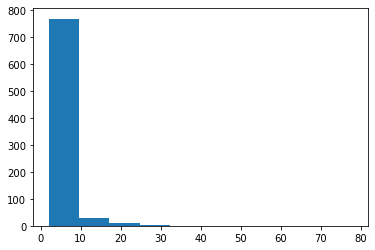

In [53]:
plt.hist(G_pl.degree().values());

Comment on the similarities.

**Your answer here:** BA network was a good fit in terms of degree distribution but it has a very small clustering coefficient due to its random wirings. Using the clustered power law model, we are able to obtain a graph with a higher clustering coefficient since the graph has a more regular connectivity pattern due to the clusters. Also, it still displays a power-law degree distribution.